In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize,OneHotEncoder
from itertools import cycle
from sklearn.model_selection import KFold


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
df=pd.read_csv(r'\RDM\Respiratory_Sound_Database\diagnosis_details.csv')
df.head()

,patient_id,diagnosis,recording_index,chest_location,acquisition_mode,recording_equipment
0,101,URTI,1b1,Al,sc,Meditron
1,101,URTI,1b1,Pr,sc,Meditron
2,102,Healthy,1b1,Ar,sc,Meditron
3,103,Asthma,2b2,Ar,mc,LittC2SE
4,104,COPD,1b1,Al,sc,Litt3200


In [ ]:
df.info()

In [12]:
#for prediction we only need first wo columns
df=df.iloc[:,:2]
df.head(1)

,patient_id,diagnosis
0,101,URTI


In [13]:
count=df['diagnosis'].value_counts()
count

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: diagnosis, dtype: int64

In [14]:
audio_files=glob.glob(r'\Lea!n\RDM\Respiratory_Sound_Database\audio_and_txt_files\*.wav')
print(os.path.basename(audio_files[0]).split('_')[0])

101


In [15]:
#new_file_name = f"{os.path.splitext(audio_files[0])[0]}_aug_{np.random.randint(1000)}{os.path.splitext(audio_files[0])[1]}"
new_file_name=f"{os.path.splitext(audio_files[0])[0]}_aug_{4}{os.path.splitext(audio_files[0])[1]}"
print(new_file_name)

\RDM\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_4.wav


In [20]:
df2=pd.read_csv(r'\Lea!n\RDM\Respiratory_Sound_Database\patient_diagnosis.csv',names=['patient_id','diagnosis'])
df2.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [25]:
#checking values in new data
audio_files2=glob.glob(r'\Lea!n\RDM\Respiratory_Sound_Database\audio_and_txt_files\*.wav')


In [26]:
len(audio_files2)

6524

## Feature extraction

In [17]:
#function for extracting class labels
def extract_label(file,df):
    id=os.path.basename(file).split('_')[0]
    label=df[df['patient_id']==int(id)]['diagnosis'].values[0]
    return label


#function for extracting mfcc features
def feature_extraction(file,max_pad_len,n_features):
# Load the .wav file
    audio, sample_rate = librosa.load(file)
    # Extract the MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=n_features)
    
    # If the array is shorter than max_pad_len, pad it with zeros
    if (mfccs.shape[1] < max_pad_len):
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # If the array is longer than max_pad_len, truncate it
    elif (mfccs.shape[1] > max_pad_len):
        mfccs = mfccs[:, :max_pad_len]
        
    return mfccs


In [27]:
mfccs_features=[]
length=[]
labels=[]
max_pad_len=926
for i in audio_files2:
    mfccs=feature_extraction(i,max_pad_len,52)
    mfccs_features.append(mfccs)
    labels.append(extract_label(i,df2))
    length.append(mfccs.shape[1])

In [36]:
#converting fatures and labels to numpy arrays
mfccs_features=np.array(mfccs_features)
labels=np.array(labels)
print(f"features shape{mfccs_features.shape}")
print(f"Labels shape{labels.shape}")


features shape(6524, 52, 926)
Labels shape(6524,)


In [51]:
unique_labels, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

{0: 794, 1: 816, 2: 806, 3: 793, 4: 840, 5: 796, 6: 851, 7: 828}


### Model 

In [30]:
#encoding the labels
label_encoder=LabelEncoder()
labels=label_encoder.fit_transform(labels)
one_hot_labels=to_categorical(labels,num_classes=8)
one_hot_labels


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [34]:
def create_model():
    model=Sequential([
        Input(shape=(52,926)),
        
        Conv1D(64,5,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        Conv1D(128,3,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # LSTM layers with return_sequences=True to keep temporal dimension
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        
        # Attention Layer
        SeqSelfAttention(attention_activation='sigmoid'),
        
        # Additional LSTM Layer
        LSTM(128),
        Dropout(0.5),
        
        # Dense Layers for Classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   
    return model 

### K_fold cross validation

In [40]:
# Split the dataset into training, validation, and test sets
X_train,X_test,y_train,y_test=train_test_split(mfccs_features,one_hot_labels,test_size=0.2,random_state=0)

#early stopping to prevent overfitting
early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [45]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialize a list to hold the history for each fold
histories = []

for train, val in kfold.split(X_train):
    # Define the model inside the loop
    model=create_model()

    # Use the indexes to extract the training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]

    # Fit the model for this fold
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )
    
    # Append the history to the histories list
    histories.append(history)

Epoch 1/100
131/131 [==============================] - 33s 127ms/step - loss: 1.7324 - accuracy: 0.3111 - val_loss: 1.6602 - val_accuracy: 0.3257
Epoch 2/100
131/131 [==============================] - 14s 107ms/step - loss: 1.3237 - accuracy: 0.4771 - val_loss: 1.7863 - val_accuracy: 0.3563
Epoch 3/100
131/131 [==============================] - 16s 119ms/step - loss: 1.0899 - accuracy: 0.5629 - val_loss: 1.1973 - val_accuracy: 0.4416
Epoch 4/100
131/131 [==============================] - 16s 124ms/step - loss: 0.8531 - accuracy: 0.6788 - val_loss: 1.8176 - val_accuracy: 0.3956
Epoch 5/100
131/131 [==============================] - 14s 110ms/step - loss: 0.7126 - accuracy: 0.7269 - val_loss: 0.8318 - val_accuracy: 0.7165
Epoch 6/100
131/131 [==============================] - 14s 109ms/step - loss: 0.5534 - accuracy: 0.7780 - val_loss: 1.0530 - val_accuracy: 0.6245
Epoch 7/100
131/131 [==============================] - 14s 104ms/step - loss: 0.4595 - accuracy: 0.8060 - val_loss: 0.4175 -

In [49]:
# Initialize lists to hold the final validation accuracy and loss for each fold
final_val_accs = []
final_val_losses = []

# Loop over the histories
for i, history in enumerate(histories):
    # Append the final validation accuracy and loss for each fold to the lists
    print(f'Fold {i+1} - Validation accuracy: {history.history["val_accuracy"][-1]}, Validation loss: {history.history["val_loss"][-1]}')
    final_val_accs.append(history.history['val_accuracy'][-1])
    final_val_losses.append(history.history['val_loss'][-1])

# Calculate the average final validation accuracy and loss across all folds
avg_val_acc = sum(final_val_accs) / len(final_val_accs)
avg_val_loss = sum(final_val_losses) / len(final_val_losses)

print(f'Average validation accuracy: {avg_val_acc}')
print(f'Average validation loss: {avg_val_loss}')

Fold 1 - Validation accuracy: 0.992337167263031, Validation loss: 0.05662860348820686
Fold 2 - Validation accuracy: 0.8649425506591797, Validation loss: 0.21343034505844116
Fold 3 - Validation accuracy: 0.9894636273384094, Validation loss: 0.07473954558372498
Fold 4 - Validation accuracy: 0.9530651569366455, Validation loss: 0.40023720264434814
Fold 5 - Validation accuracy: 0.8782358765602112, Validation loss: 0.3324316442012787
Average validation accuracy: 0.9356088757514953
Average validation loss: 0.21549346819519996


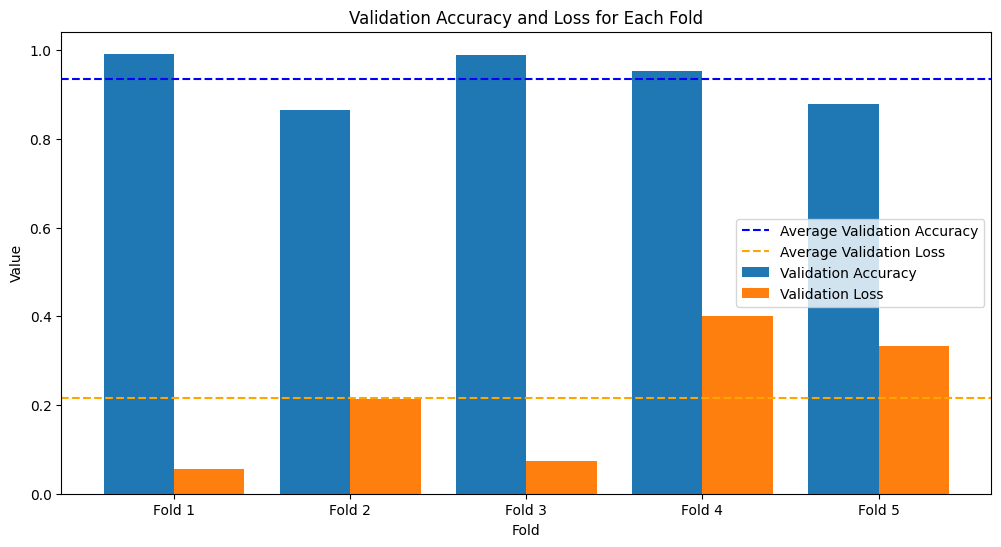

In [50]:
# Create an array with the positions of each bar on the x-axis
x = np.arange(len(final_val_accs))

# Create a bar chart of the validation accuracy
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, final_val_accs, 0.4, label='Validation Accuracy')
plt.bar(x + 0.2, final_val_losses, 0.4, label='Validation Loss')

# Add the average validation accuracy and loss as horizontal lines
plt.axhline(avg_val_acc, color='blue', linestyle='dashed', label='Average Validation Accuracy')
plt.axhline(avg_val_loss, color='orange', linestyle='dashed', label='Average Validation Loss')

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Value')
plt.title('Validation Accuracy and Loss for Each Fold')
plt.xticks(x, [f'Fold {i+1}' for i in range(len(final_val_accs))])

# Add a legend
plt.legend()

# Show the chart
plt.show()

In [26]:
# #applying one_hot encoding
# encoder=OneHotEncoder(sparse=False,handle_unknown='ignore')
# y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
# y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

In [48]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

41/41 [==============================] - 3s 71ms/step - loss: 0.2431 - accuracy: 0.8552
Test Loss: 0.24310976266860962
Test Accuracy: 0.8551723957061768
